In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation
import pickle
import pandas as pd
#import pyret
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve1d
from numpy import unravel_index
import scipy
from scipy.interpolate import interp1d
import h5py

# read STAs and chirp responses

In [2]:
#read sta info
experiment_name = 'MR-0609'
filename = f'/Users/simone/Documents/Experiments/Spatiotemporal_tuning_curves/STA/{experiment_name}/sta_data.pkl'

with open(filename, "rb") as handle:   #Pickling
    stadict = pickle.load(handle)
    


fpdata = f'/Users/simone/Documents/Experiments/Spatiotemporal_tuning_curves/Results/{experiment_name}/data.pkl'

with open(fpdata, "rb") as handle:   #Pickling
    datadict = pickle.load(handle)
    
  
    
    STAs = []
temporal = []
spatial = []
counts = []
chirps = []


for temp in stadict.keys():

    STAs.append(stadict[temp]['sta'])
    temporal.append(stadict[temp]['time_rf'])
    spatial.append(stadict[temp]['space_rf'])
    counts.append(stadict[temp]['count'])
    chirps.append(datadict[temp]['psth_chirp'])

    
nb_bins = stadict[temp]['count'].shape[0]

# load checkerpoard stimulus

In [5]:
# load stimulus
fpstim  = f'/Users/simone/Documents/Experiments/Spatiotemporal_tuning_curves/stimuli/{experiment_name}_checker/checkerboard_nd4_stim.mat'

stim =h5py.File(fpstim, 'r')
nb_frames = len(stim['stim'])
nb_checks = stim[stim['stim'][0][0]][()].shape[0]


stimmat = np.zeros((nb_frames, nb_checks,nb_checks))
for i in range(int(nb_frames/2)):
    frame = stim[stim['stim'][i][0]][()]
    stimmat[i,:,:] = frame

#stimmat2 = np.rot90(np.fliplr(stimmat))
stimmat = np.rot90(np.fliplr(stimmat), axes=(1,2),k = 3)


In [128]:
stimshape = (stimmat.shape[1],stimmat.shape[2])

# load checkerboard responses

In [6]:
# # load response

# # load  binned spikes
# fpspikes = f'/user/sebert/home/Documents/Experiments/Spatiotemporal_tuning_curves/STA/{experiment_name}/spikes_count_checkerboard_nd4.txt'
# spikes = np.loadtxt(fpspikes)
# nb_bins = spikes.shape[1]

 
# filename = "/user/sebert/home/Documents/Experiments/OSR/Results/20210326_Thomas/resultfiles/sta_data.pkl"
# with open(filename, "rb") as handle:   #Pickling
#     stadict = pickle.load(handle)
    
# stadict.keys()


# rasters_check_rep = stadict['rasters_check_repeated']
# rasters_check = stadict['rasters_check']

# repeated_checker_response = np.asarray(rasters_check_rep[c])

# nb_repeats = len(repeated_checker_response)


# # counts for repeated 
# counts = []
# for rep in range(nb_repeats):
#     countt,bins = np.histogram(repeated_checker_response[rep], bins = 600, range = (0,15))
#     counts.append(countt)


# # counts concatenated
# count,bins = np.histogram(np.concatenate(repeated_checker_response), bins = 600, range = (0,15))
# count = count/nb_repeats

# choos a cell with a good STA

In [159]:
c = 5
sta = STAs[c]

sta -= sta.mean()
sta /= sta.std()

time_rf = temporal[c]
space_rf = spatial[c]
count = counts[c]

framerate = 30.0
dt = 1/framerate
temporal_dimension = 12
time = np.arange(0,nb_bins)*dt
ftime = np.arange(0,temporal_dimension)*dt
ftime = np.flip(ftime)*-1




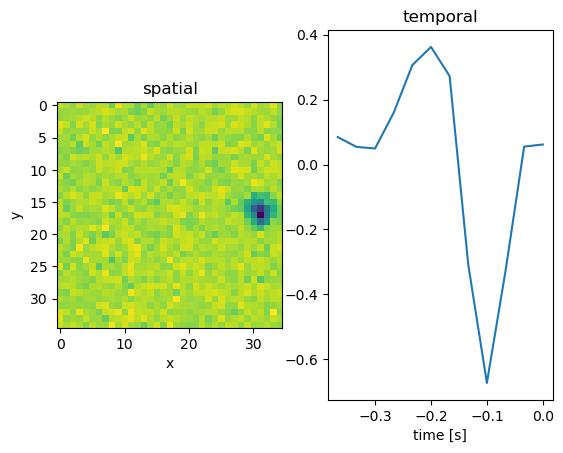

Text(0.5, 1.0, 'checker response')

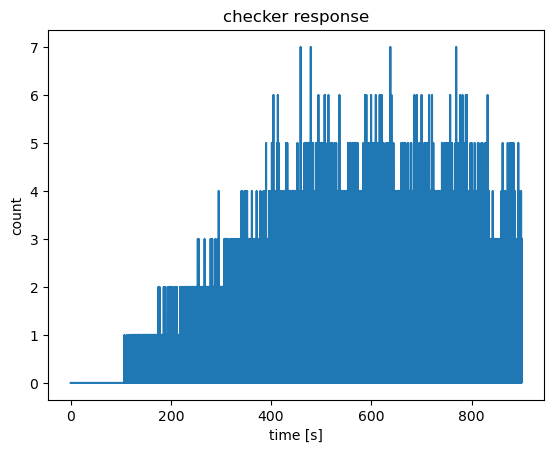

In [160]:
# visualize STA
fig = plt.figure()
spatial_dimension = (sta.shape[1],sta.shape[2])

ax3 = fig.add_subplot(122)
ax3.plot(ftime,time_rf)
ax3.set_xlabel('time [s]')
ax3.set_ylabel('Stimulus Intensity')
ax3.set_title('temporal')


ax2 = fig.add_subplot(121)
ax2.imshow(space_rf)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('spatial')


plt.show()



# plot checker response
fig = plt.figure()
plt.plot(time,count)
plt.xlabel('time [s]')
plt.ylabel('count')
plt.title('checker response')

In [161]:
len(np.nonzero(count)[0]),len(time),time[-1]/60

(12750, 27001, 15.0)

# Linear Predictions with STA from data

convoution of stimulus and filter. Numerically compute dot product.


In [147]:
def design_matrix_2D(stimulus,td=12):
    
    stimulus_timesteps = stimulus.shape[0]+td
    preceeding_stimulus_length = stimulus.shape[1]*stimulus.shape[2]*td
    
    stimulus_padded = np.concatenate((np.zeros((td,stimulus.shape[1],stimulus.shape[2])),stimulus))
    X = np.zeros((stimulus_timesteps,preceeding_stimulus_length))
    
    for t in range(stimulus_timesteps):
        if t < td:
            continue
        else:
            X[t,:] = stimulus_padded[t-td:t,:,:].ravel()
        
    return X[td:,:]


    
def predict_2D(stimulus,sta):

    X = design_matrix_2D(stimulus)

    return np.dot(X, sta.flatten())
    return X @sta.flatten()

     
    
def predict(stimulus,sta):


    return np.convolve(stimulus,sta, mode = 'full')[:-len(sta)+1]

        

def visualize_stimulus_response(stim,response,stimt,dt):


    fig = plt.figure()

    axstim = fig.add_subplot(121)
    axstim.imshow(stim[0,:,:],vmax = 1, vmin = 0)
    axstim.set_title('Stimulus')
    axstim.set_xlabel('x')
    axstim.set_ylabel('y')


    time = np.arange(0,stimt,dt)
    axres = fig.add_subplot(122)
    axres.plot(time,response/response.max(), label = 'response prediction')
    axres.plot(time,np.flip(time_rf)/time_rf.max(), label = 'temporal filter profile', color = 'blue', alpha = .2, linewidth = 6)

    axres.set_xlabel('time [s]')
    axres.set_title('Response')
    
    fig.legend()

    plt.show()

In [148]:
response_check = predict_2D(stimmat,sta)
response_check = np.asarray(response_check)

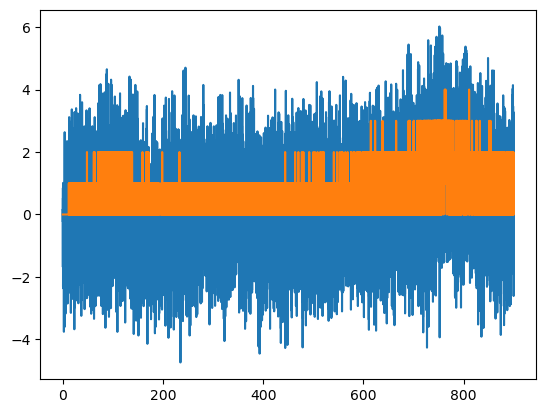

In [149]:
#count = (count-count.mean())/count.std()
response_check = (response_check-response_check.mean())/response_check.std()
response_check = response_check[:int(len(response_check)/2)]

plt.plot(time,response_check)
plt.plot(time,count)


# get nonlinearity

In [103]:
# fit sigmoid 

def sig(x, slope,threshold,max_val):

    return max_val/ (1 + np.exp(-slope * (x - threshold)))

#popt, pcov = scipy.optimize.curve_fit(sig, fx[:-1],fy[:-1])


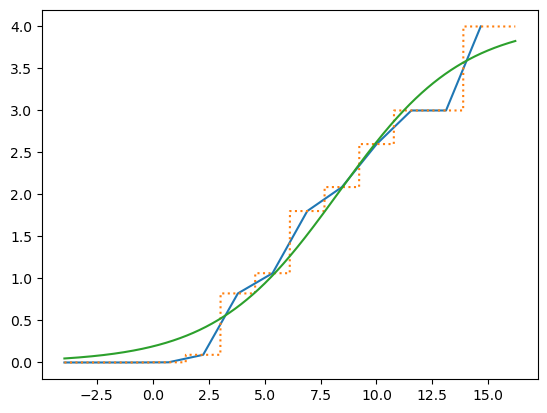

In [105]:
# get nonlinearity

spikes_binned = count
num_fbins = 14
rep = 0 
mean_fx = np.zeros(num_fbins)
mean_fy = np.zeros(num_fbins)
# bin filter output and get bin index for each filtered stimulus
countpred,bin_edges = np.histogram(response_check,num_fbins)
bin_idx = np.digitize(response_check, bins=bin_edges) - 1
fx = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2 # use bin centers for x positions

# now compute mean spike count in each bin
fy = np.zeros(num_fbins) # y values for nonlinearity
for jj in np.arange(num_fbins):
    fy[jj] = np.mean(spikes_binned[bin_idx==jj])
#fy = fy/(bin_edges[1]-bin_edges[0]) # divide by bin size to get units of sp/s;
fnlin = interp1d(fx[:-1],fy[:-1],kind='nearest', bounds_error=False, fill_value='extrapolate')
fxrange = np.arange(np.min(fx),np.max(fx),0.01)
fyrange = fnlin(fxrange)
plt.plot(fx,fy)
plt.plot(fxrange,fyrange, linestyle = ':')

popt, pcov = scipy.optimize.curve_fit(sig, fxrange,fyrange)

#plt.plot(fx,sig(fx,1,0,60))
plt.plot(fxrange,sig(fxrange,*popt))


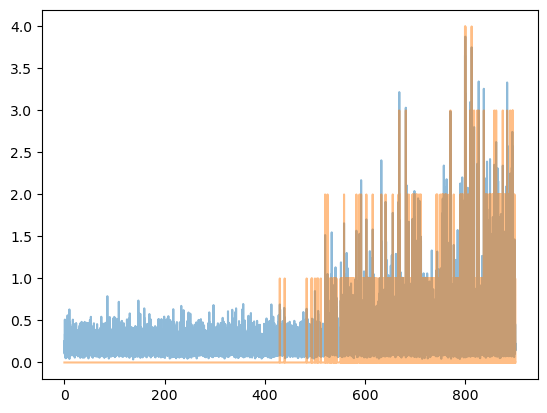

In [108]:
plt.plot(time,sig(response_check,*popt), alpha = 0.5)
plt.plot(time,count, alpha = 0.5)

# Predict Chirp Response

In [130]:

framerate = 60.
stim_length = 35.0
bin_size = 0.001
fontsize = 20

time_PSTH = np.arange(0,stim_length,bin_size)
time_stim = np.arange(0,stim_length,1/framerate)

chirp = chirps[c]
chirp = np.asarray(chirp)/10
chirp_stim = datadict['stimuli']['chirp']['stim']
chirp_stim_2D = np.zeros((len(chirp_stim),stimshape[0],stimshape[1]))
                         
for t,val in enumerate(chirp_stim):
    chirp_stim_2D[t,:,:] = val


len(chirp), len(chirp_stim)

(35000, 2100)

In [132]:
response_chirp_lin = predict(chirp_stim,np.flip(time_rf))
response_chirp_lin_test = predict_2D(chirp_stim_2D,sta)
response_chirp = sig(response_chirp_lin,*popt)
response_chirp_test = sig(response_chirp_lin_test,*popt)
len(response_chirp)

2100

In [135]:
chirp = (chirp-chirp.mean())/chirp.std()
response_chirp = (response_chirp-response_chirp.mean())/response_chirp.std()
response_chirp_test = (response_chirp_test-response_chirp_test.mean())/response_chirp_test.std()

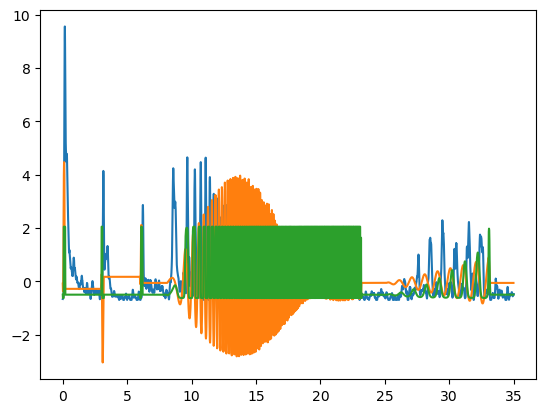

In [136]:
plt.plot(time_PSTH,chirp)
plt.plot(time_stim,response_chirp)
plt.plot(time_stim,response_chirp_test)

# Predict resonse to STP stim